In [4]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error

In [5]:
warnings.filterwarnings('ignore')

In [6]:
# Load data
df = pd.read_csv('HWII_data_Hashemi.csv')
df.columns = ['date', 'time-period', 'job-vacancy-rate']
df.head()

,date,time-period,job-vacancy-rate
0,2010-12-31,2010Q4,0.8
1,2011-03-31,2011Q1,0.8
2,2011-06-30,2011Q2,1.0
3,2011-09-30,2011Q3,1.1
4,2011-12-31,2011Q4,0.7


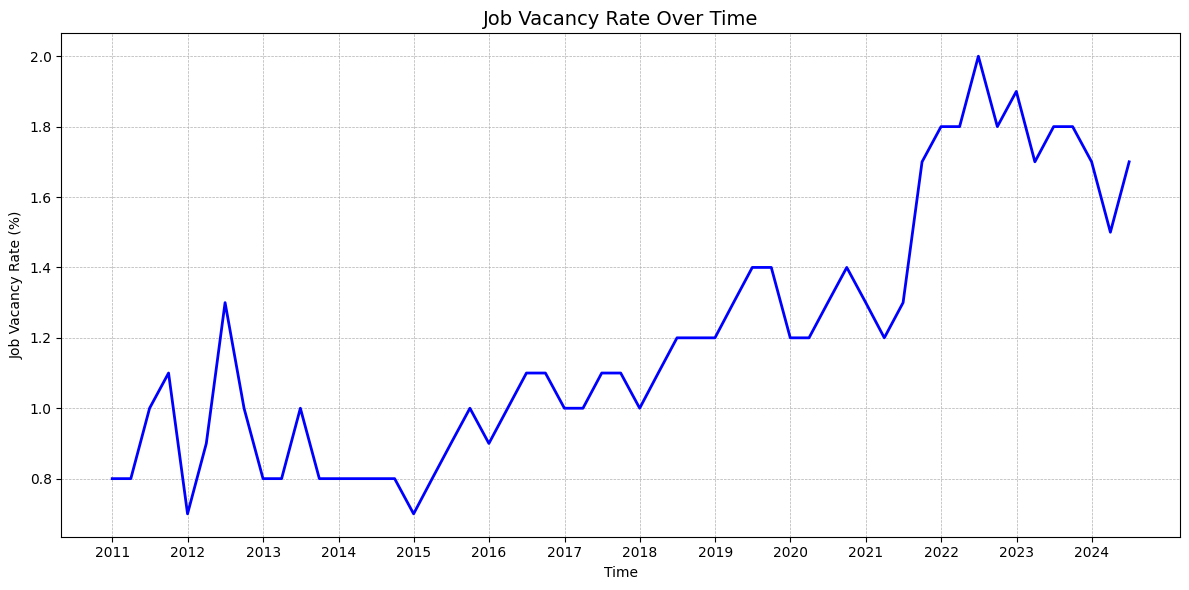

In [7]:
df['date_time'] = pd.to_datetime(df['date'])
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['date_time'], df['job-vacancy-rate'], color='blue', linewidth=2)
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('Time', fontsize=10)
ax.set_ylabel('Job Vacancy Rate (%)', fontsize=10)
ax.set_title('Job Vacancy Rate Over Time', fontsize=14)

# Formatting the x-axis
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
ax.set_xticks(pd.date_range(start=df['date_time'].min(), end=df['date_time'].max(), freq='YS'))

plt.tight_layout()
plt.show()
df.drop(columns=['date_time'], inplace=True)

## [STATIONARITY & TRANSFROMATIONS]

### Data Cleaning
Clean the data of outliers or breaks.

In [8]:
# having any missing values?
if df.isnull().sum().all() == 0:
    print('No missing values')
else:
    print('There are missing values')

No missing values


Let's plot the histogram of data, to recognize the outliers

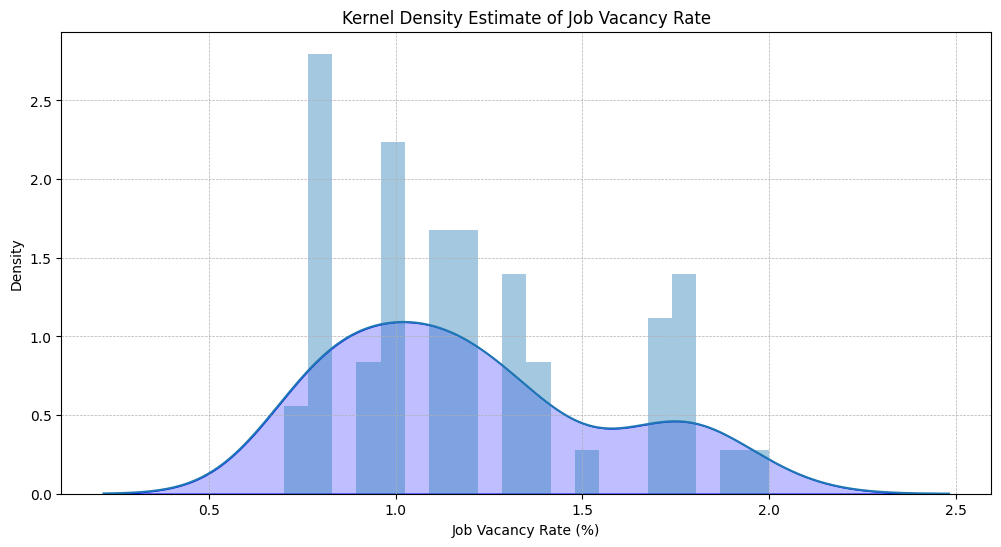

In [9]:
import seaborn as sns

# Assuming df is already defined and contains 'job-vacancy-rate' column

plt.figure(figsize=(12, 6))
sns.kdeplot(df['job-vacancy-rate'], shade=True, color='blue')
sns.distplot(df['job-vacancy-rate'], bins=20)
plt.title('Kernel Density Estimate of Job Vacancy Rate')
plt.xlabel('Job Vacancy Rate (%)')
plt.ylabel('Density')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#### Outlier removing using IQR

In [10]:
Q1 = df['job-vacancy-rate'].quantile(0.25)
Q3 = df['job-vacancy-rate'].quantile(0.75)
IQR = Q3 - Q1
k = 4

indices = (df['job-vacancy-rate'] < (Q1 - k * IQR)) | (df['job-vacancy-rate'] > (Q3 + k * IQR))

if indices.sum() > 0:
    print('There are outliers')
else:
    print('No outliers')

No outliers


#### Outlier removing using Isolation forest

Number of detected outliers: 2


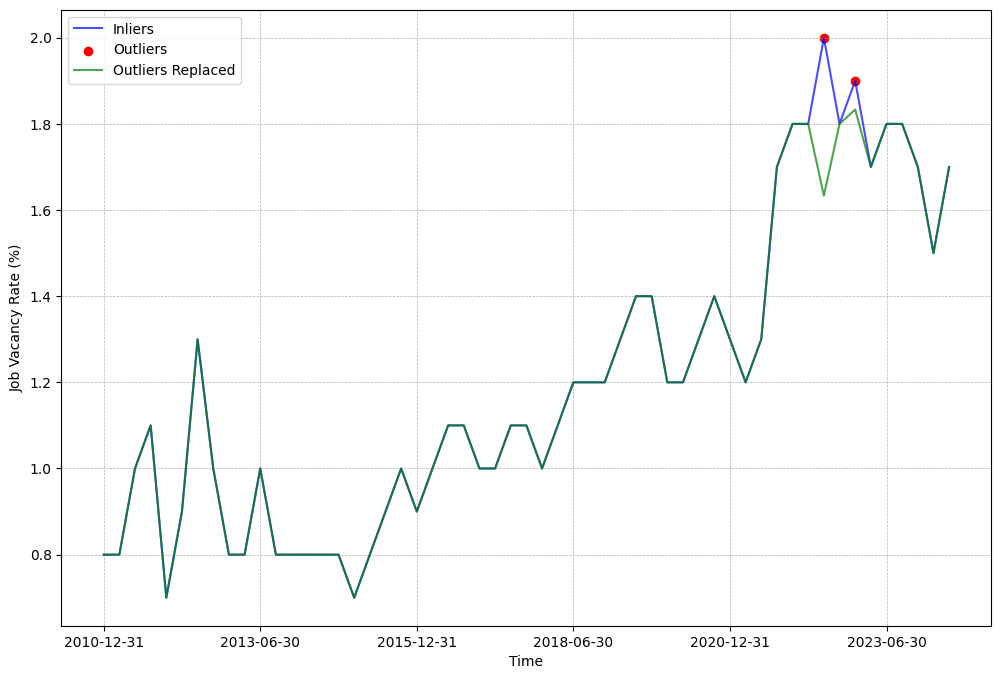

In [11]:
isolation_forest_model = IsolationForest(contamination=0.05, random_state=42)
df['outlier'] = isolation_forest_model.fit_predict(df[['job-vacancy-rate']])
df['outlier'] = df['outlier'] == -1

print(f"Number of detected outliers: {df['outlier'].sum()}")

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['job-vacancy-rate'], label='Inliers', color='blue', alpha=0.7)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(np.arange(0, len(df['date']), 10))       # set ticks every ten
plt.scatter(df['date'][df['outlier']], df['job-vacancy-rate'][df['outlier']], color='red', label='Outliers', marker='o')
plt.xlabel('Time')
plt.ylabel('Job Vacancy Rate (%)')

window_size = 6
# replace otliers with the mean of the window
df['job-vacancy-rate'] = np.where(df['outlier'], df['job-vacancy-rate'].rolling(window=window_size, min_periods=1).mean(), df['job-vacancy-rate'])
plt.plot(df['date'], df['job-vacancy-rate'], label='Outliers Replaced', color='green', alpha=0.7)

plt.legend(loc='upper left')
plt.show()

df.drop(columns=['outlier'], inplace=True)

### Data being stationary or not
Decide and describe whether the series is stationary or not. Support your argument with ACF and PACF functions, as well as statistical tests.

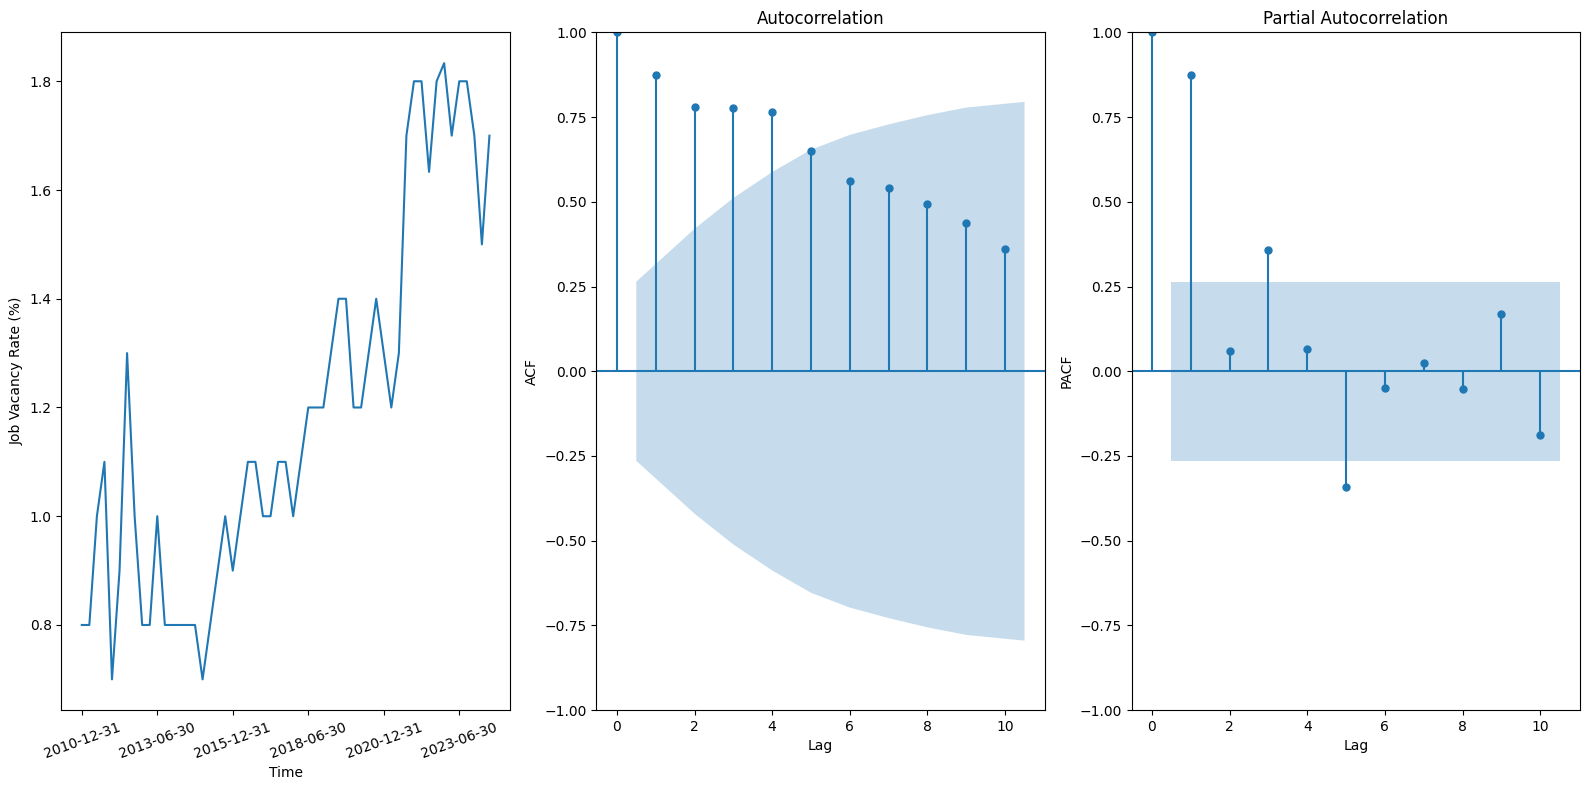

In [12]:
# plots 
fig, axs = plt.subplots(1, 3,figsize=(16,8))
axs[0].plot(df['job-vacancy-rate'])
axs[0].set_xticks(np.arange(0,len(df['job-vacancy-rate']),10))                                                       # display every 10-th tick
axs[0].set_xticklabels(df.date[np.arange(0,len(df['job-vacancy-rate']),10)],rotation=20)                             # label ticks
axs[0].set_xlabel('Time', fontsize=10)
axs[0].set_ylabel('Job Vacancy Rate (%)', fontsize=10)

sm.graphics.tsa.plot_acf(df['job-vacancy-rate'], lags=10, ax=axs[1])
axs[1].set_xlabel('Lag', fontsize=10)
axs[1].set_ylabel('ACF', fontsize=10)

sm.graphics.tsa.plot_pacf(df['job-vacancy-rate'], lags=10, ax=axs[2])
axs[2].set_xlabel('Lag', fontsize=10)
axs[2].set_ylabel('PACF', fontsize=10)

plt.tight_layout()
plt.show()

#### ACF
- The coefficients gradually decrease as the lag increases, but they remain significant up to a certain lag, indicating some level of persistence or trend in the series.
- If many lags are outside the confidence interval, it suggests that the series is not purely random and may have a trend or seasonality.

#### PACF
- The partial autocorrelation drops off sharply after lag 1, suggesting that the primary influence on the job vacancy rate is from the most recent observation. The drop-off pattern is useful for determining the order of an autoregressive (AR) model.

#### Statistical tests

In [13]:
### ADF Test
print("Results of Augmented Dickey-Fuller test:")

ADF_test_res = sm.tsa.adfuller(df['job-vacancy-rate'], maxlag=None, regression='ct', autolag='AIC')

print(f"Test Statistic:{ADF_test_res[0]}")
print(f"p-value:{ADF_test_res[1]}")
print(f"#Lags Used:{ADF_test_res[2]}")
print(f"#Observations Used:{ADF_test_res[3]}")

print("Regarding p-value:")
if ADF_test_res[1] <= 0.05:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Can not reject the null hypothesis - Data is non-stationary")


print()
print("-----------------------------------")
print()

# KPSS Test
print("Results of KPSS test:")
KPSS_test_res = sm.tsa.kpss(df['job-vacancy-rate'], regression='ct', nlags='auto')
print(f"Test Statistic:{KPSS_test_res[0]}")
print(f"p-value:{KPSS_test_res[1]}")

print("Regarding p-value:")
if KPSS_test_res[1] <= 0.05:
    print("Reject the null hypothesis - Data is non-stationary")
else:
    print("Can not reject the null hypothesis - Data is stationary")

Results of Augmented Dickey-Fuller test:
Test Statistic:-2.018766885161577
p-value:0.5911745055282748
#Lags Used:11
#Observations Used:43
Regarding p-value:
Can not reject the null hypothesis - Data is non-stationary

-----------------------------------

Results of KPSS test:
Test Statistic:0.22067877761324528
p-value:0.01
Regarding p-value:
Reject the null hypothesis - Data is non-stationary


### Transformation
Explain which transformation you will use to make the series stationary and ready for modelling.

First-order differencing: Subtracting each data point from the previous one to remove trends. 

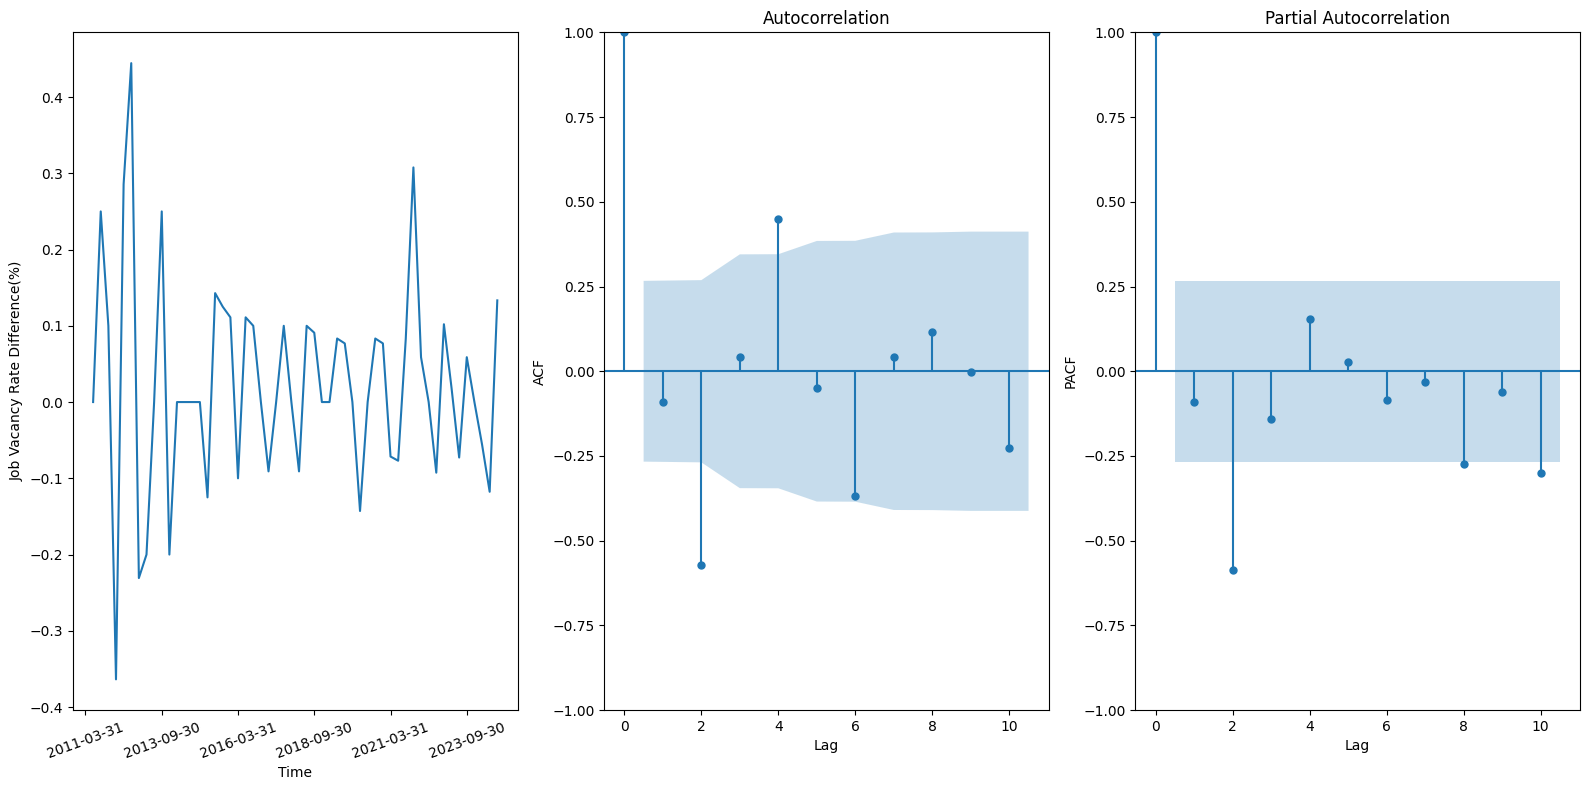

In [14]:
'''
Plot first differences of the series and AC& PAC

pct_change()
Computes the fractional change from the immediately previous row by default. 
This is useful in comparing the fraction of change in a time series of elements.
'''
df_diff = pd.DataFrame()   
df_diff['dy'] = df['job-vacancy-rate'].pct_change()
df_diff['date'] = pd.to_datetime(df['date']).dt.date
df_diff = df_diff.dropna()

df_diff
fig, axs = plt.subplots(1, 3,figsize=(16,8))
axs[0].plot(df_diff['dy'])
axs[0].set_xticks(np.arange(0,len(df_diff['dy']),10))                                                       # display every 10-th tick
axs[0].set_xticklabels(df_diff.date[np.arange(1,len(df_diff['dy'])+1,10)],rotation=20)                            # label ticks
axs[0].set_xlabel('Time', fontsize=10)
axs[0].set_ylabel('Job Vacancy Rate Difference(%)', fontsize=10)

sm.graphics.tsa.plot_acf(df_diff['dy'], lags=10, ax=axs[1])
axs[1].set_xlabel('Lag', fontsize=10)
axs[1].set_ylabel('ACF', fontsize=10)

sm.graphics.tsa.plot_pacf(df_diff['dy'], lags=10, ax=axs[2])
axs[2].set_xlabel('Lag', fontsize=10)
axs[2].set_ylabel('PACF', fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
Q1 = df_diff['dy'].quantile(0.25)
Q3 = df_diff['dy'].quantile(0.75)
IQR = Q3 - Q1
k = 4

indices = (df_diff['dy'] < (Q1 - k * IQR)) | (df_diff['dy'] > (Q3 + k * IQR))

if indices.sum() > 0:
    print('There are outliers')
else:
    print('No outliers')

No outliers


Number of detected outliers: 3


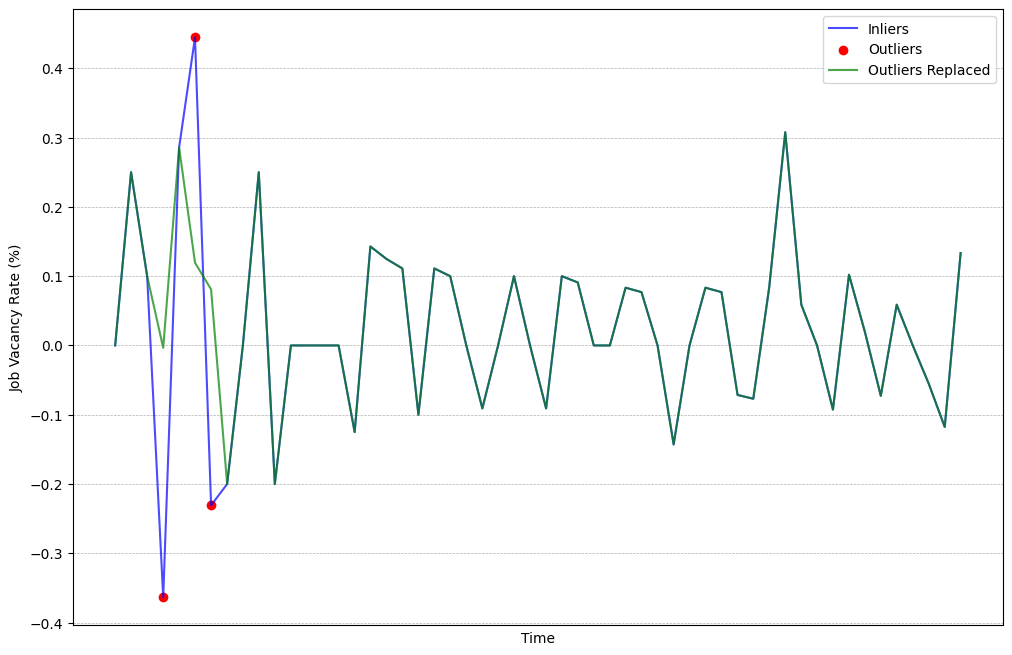

In [16]:
isolation_forest_model = IsolationForest(contamination=0.05, random_state=42)
df_diff['outlier'] = isolation_forest_model.fit_predict(df_diff[['dy']])
df_diff['outlier'] = df_diff['outlier'] == -1

print(f"Number of detected outliers: {df_diff['outlier'].sum()}")

plt.figure(figsize=(12, 8))
plt.plot(df_diff['date'], df_diff['dy'], label='Inliers', color='blue', alpha=0.7)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(np.arange(0, len(df_diff['date']), 10))       # set ticks every ten
plt.scatter(df_diff['date'][df_diff['outlier']], df_diff['dy'][df_diff['outlier']], color='red', label='Outliers', marker='o')
plt.xlabel('Time')
plt.ylabel('Job Vacancy Rate (%)')

window_size = 6
# replace otliers with the mean of the window
df_diff['dy'] = np.where(df_diff['outlier'], df_diff['dy'].rolling(window=window_size, min_periods=1).mean(), df_diff['dy'])
plt.plot(df_diff['date'], df_diff['dy'], label='Outliers Replaced', color='green', alpha=0.7)

plt.legend(loc='upper right')
plt.show()

df_diff.drop(columns=['outlier'], inplace=True)

In [17]:
### ADF Test
print("Results of Augmented Dickey-Fuller test:")

ADF_test_res = sm.tsa.adfuller(df_diff['dy'], maxlag=None, regression='c', autolag='AIC')

print(f"Test Statistic:{ADF_test_res[0]}")
print(f"p-value:{ADF_test_res[1]}")
print(f"Number of Lags Used:{ADF_test_res[2]}")
print(f"Number of Observations Used:{ADF_test_res[3]}")

print("Regarding p-value:")
if ADF_test_res[1] <= 0.05:                                     # H0: Data is non-stationary, H1: Data is stationary
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Can not reject the null hypothesis - Data is non-stationary")


print()
print("-----------------------------------")
print()

# KPSS Test
print("Results of KPSS test:")
KPSS_test_res = sm.tsa.kpss(df_diff['dy'], regression='c', nlags='auto')
print(f"Test Statistic:{KPSS_test_res[0]}")
print(f"p-value:{KPSS_test_res[1]}")

print("Regarding p-value:")
if KPSS_test_res[1] <= 0.05:                                  # H0: Data is stationary, H1: Data is non-stationary
    print("Reject the null hypothesis - Data is non-stationary")
else:
    print("Can not reject the null hypothesis - Data is stationary")

Results of Augmented Dickey-Fuller test:
Test Statistic:-5.310432687759314
p-value:5.209662828184297e-06
Number of Lags Used:9
Number of Observations Used:44
Regarding p-value:
Reject the null hypothesis - Data is stationary

-----------------------------------

Results of KPSS test:
Test Statistic:0.2473219814991699
p-value:0.1
Regarding p-value:
Can not reject the null hypothesis - Data is stationary


## [ARIMA MODEL]

Take the stationary series from point 1, use the first 80% of the sample for estimation, and select an appropriate ARIMA model. Justify your choice by means of tests and selection criteria.

In [18]:
'''
p - AR model lags - number of pas values used to predict the current observation
d - differencing order - number of times the series has been differenced
q - MA model lags - number of past errors used to predict the current observation
'''

# taking 80% of the data as training set
train_size = int(len(df) * 0.8)
train, test = df_diff['dy'][:train_size], df_diff['dy'][train_size:]

# estimate ICs
IC = sm.tsa.stattools.arma_order_select_ic(train, max_ar=4, max_ma=4, ic=['aic','bic','hqic'], trend='c')
# display optimal lags
print(f"min AIC at (p,q): {(int(IC.aic_min_order[0]), int(IC.aic_min_order[1]))}")
print(f"min BIC at (p,q): {(int(IC.bic_min_order[0]), int(IC.bic_min_order[1]))}")
print(f"min HQIC at (p,q): {(int(IC.hqic_min_order[0]), int(IC.hqic_min_order[1]))}")

# Choose (p, q) based on BIC
p, q = IC.bic_min_order

# d = 1 since the series is differenced once
d = 1


# ARIMA model
arima_model = sm.tsa.ARIMA(train, order=(p, d, q))
arima_result = arima_model.fit()

# Print summary of the model
print(arima_result.summary())

min AIC at (p,q): (2, 2)
min BIC at (p,q): (2, 2)
min HQIC at (p,q): (2, 2)
                               SARIMAX Results                                
Dep. Variable:                     dy   No. Observations:                   44
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  33.100
Date:                Mon, 04 Nov 2024   AIC                            -56.201
Time:                        06:12:55   BIC                            -47.395
Sample:                             0   HQIC                           -52.953
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1486      0.361      0.412      0.680      -0.558       0.855
ar.L2         -0.5930      0.192     -3.081      0.002 

Ljung-Box and Box-Pierce for residual autocorrelation
      lb_stat  lb_pvalue   bp_stat  bp_pvalue
1    0.078312   0.779599  0.073204   0.786727
2    0.091088   0.955478  0.084869   0.958453
3    0.125154   0.988657  0.115233   0.989949
4    0.853915   0.931077  0.748938   0.945160
5    2.187811   0.822595  1.879850   0.865508
6    9.962828   0.126226  8.302690   0.216756
7   10.315155   0.171406  8.586083   0.283754
8   10.319912   0.243286  8.589807   0.378071
9   11.658585   0.233248  9.608362   0.383110
10  11.731720   0.303413  9.662419   0.470593
Heteroscedasticity test results:
P-val: 0.05322987042800739


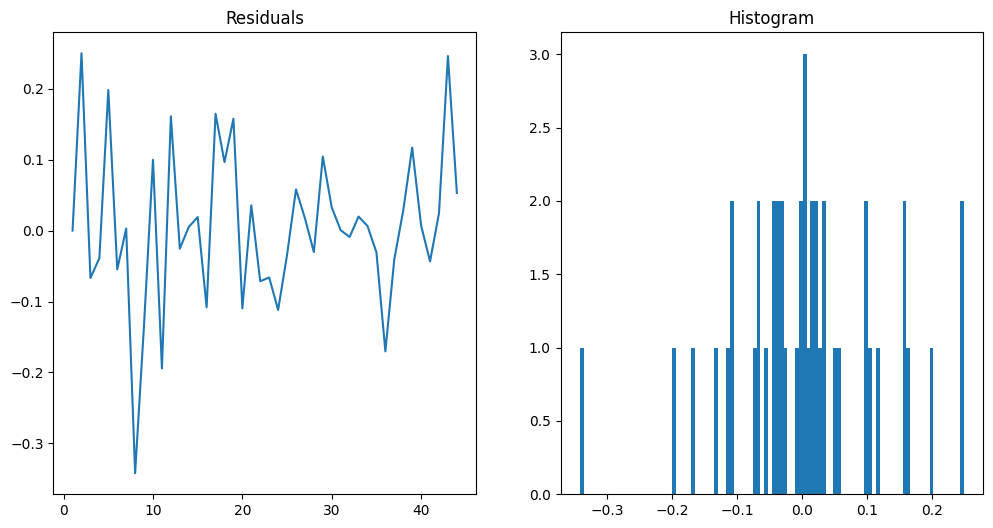

In [22]:
# Plot residuals
fig, axs = plt.subplots(1, 2,figsize=(12,6))
axs[0].plot(arima_result.resid)
axs[0].set_title("Residuals")
axs[1].hist(arima_result.resid,bins=100)
axs[1].set_title("Histogram")

# Test for whiteness of residuals 
print("Ljung-Box and Box-Pierce for residual autocorrelation")
res_lb = sm.stats.diagnostic.acorr_ljungbox(arima_result.resid, lags=10, boxpierce=True,model_df=0+0)
print(res_lb)

# Test for heteroscedasticity
res_het = sm.tsa.stattools.breakvar_heteroskedasticity_test(arima_result.resid, subset_length=1/3, alternative='two-sided')
print("Heteroscedasticity test results:")
print(f"P-val: {res_het[1]}")

- If the p-values are high (generally above 0.05), this suggests that there is no significant autocorrelation between residuals, indicating a good model fit.

## [FORECASTS]

Use the model from point 2 and perform **one-step-ahead** forecasts, with expanding window, for your series for the remaining 20% of the sample (you can refer to the code from “Ex_multi_TS_real_data.ipynb”). Plot the forecasts and the true values. Also, report the RMSE of the forecasts. You will later compare this RMSE to the RMSE obtained in a VAR and NN model. For example, if you have 100 observations, the 1st one-step-ahead forecast: Estimate the model on T = 1...80 and forecast the value for T=81. The 2nd one-step-ahead forecast: Estimate the model on T = 1...81 and forecast T=82, and so on. 

RMSE: 0.06733497633143967


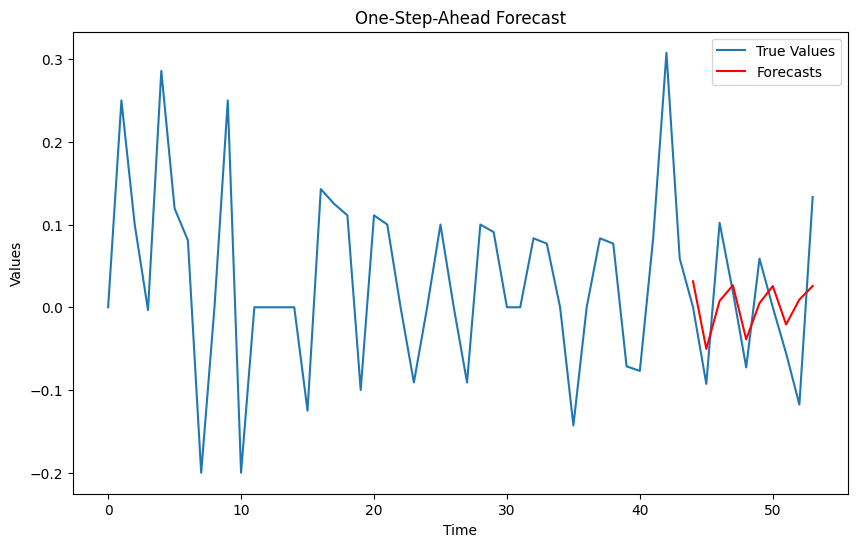

In [25]:
predictions = []
true_test_values = test.values  

for i in range(len(test)):
    model = sm.tsa.ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=1)      # one-step-ahead forecast
    predictions.append(forecast)

    train = np.append(train, test.iloc[i])      # include the next test point for the next iteration

rmse = np.sqrt(mean_squared_error(true_test_values, predictions))
print(f"RMSE: {rmse}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(df_diff['dy'])), df_diff['dy'], label='True Values')
plt.plot(range(train_size, len(df_diff['dy'])), predictions, color='red', label='Forecasts')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('One-Step-Ahead Forecast')
plt.legend()
plt.show()
